# Data Scientist task: customer segmentation
## 2021-06-26

### Robert Tarasevič

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from datetime import date
import datetime as dt
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## General overview of the data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/data_science_candidate_task.xlsx", sheet_name="data")
df.head(10)

,customer_id,order_id,order_date,city,product_id,category,sub_category,product_name,total_excl_vat,quantity,discount
0,CG-12520,CA-2016-152156,2016-11-08,Henderson,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00
1,CG-12520,CA-2016-152156,2016-11-08,Henderson,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00
2,DV-13045,CA-2016-138688,2016-06-12,Los Angeles,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00
3,SO-20335,US-2015-108966,2015-10-11,Fort Lauderdale,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45
4,SO-20335,US-2015-108966,2015-10-11,Fort Lauderdale,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20
5,BH-11710,CA-2014-115812,2014-06-09,Los Angeles,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00
6,BH-11710,CA-2014-115812,2014-06-09,Los Angeles,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800,4,0.00
7,BH-11710,CA-2014-115812,2014-06-09,Los Angeles,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20
8,BH-11710,CA-2014-115812,2014-06-09,Los Angeles,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3,0.20
9,BH-11710,CA-2014-115812,2014-06-09,Los Angeles,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000,5,0.00


Check for any missing values

In [ ]:
df.isnull().sum()

customer_id       0
order_id          0
order_date        0
city              0
product_id        0
category          0
sub_category      0
product_name      0
total_excl_vat    0
quantity          0
discount          0
dtype: int64

In [ ]:
df.nunique()

customer_id        793
order_id          5009
order_date        1237
city               531
product_id        1862
category             3
sub_category        17
product_name      1850
total_excl_vat    6144
quantity            14
discount            12
dtype: int64

The number of unique product ids and product names is different, let's check for duplicates

In [ ]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
df.drop_duplicates(inplace = True)


Duplicate entries: 1
0% rows are duplicate.


First of all, we will group our data by cities, and to be more precise, by the sum of their sales and number of unique customers

In [ ]:
sum_city = df.groupby(['city']).agg({'total_excl_vat': 'sum'}).sort_values('total_excl_vat', ascending=False)
customer_city = df.groupby('city')['customer_id'].nunique().sort_values(ascending=False).reset_index()
customer_city.columns = ['city', 'customers count']

In [ ]:
sum_city

,total_excl_vat
city,
New York City,256368.161
Los Angeles,175851.341
Seattle,119540.742
San Francisco,112669.092
Philadelphia,109077.013
...,...
Ormond Beach,2.808
Pensacola,2.214
Jupiter,2.064


In [ ]:
customer_city

,city,customers count
0,New York City,355
1,Los Angeles,304
2,Philadelphia,239
3,San Francisco,232
4,Seattle,188
...,...,...
526,Gladstone,1
527,San Gabriel,1
528,Gastonia,1
529,Gaithersburg,1


In [ ]:
not_top = len(sum_city) - 5
not_top_sum = sum_city.tail(not_top).sum()
top_cities = sum_city.head(5)
top_cities.loc['Others'] = [not_top_sum.values[0]]
top_cities

,total_excl_vat
city,
New York City,2.563682e+05
Los Angeles,1.758513e+05
Seattle,1.195407e+05
San Francisco,1.126691e+05
Philadelphia,1.090770e+05
Others,1.523413e+06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


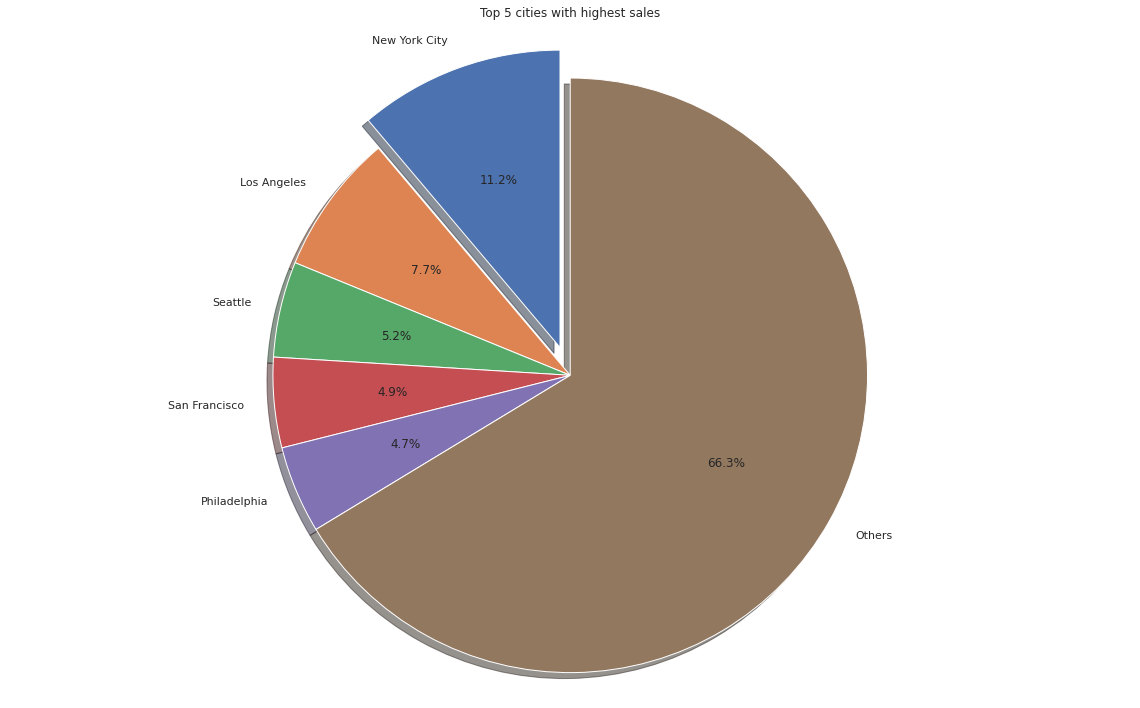

In [ ]:
# Pie chart
labels = top_cities.index
sizes = top_cities.values# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.1, 0, 0, 0, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax1.set_title('Top 5 cities with highest sales')

plt.tight_layout()
plt.show()

From both tables we can see that the top 5 cities in terms of both sales and unique customers remain the same, so for the sake of simplicity we will segment only San Francisco customers below.
## San Francisco customers segmentation

In [ ]:
SF_data = df.loc[df['city'] == "San Francisco"]
SF_data.reset_index(drop=True, inplace=True)
SF_data.head()

,customer_id,order_id,order_date,city,product_id,category,sub_category,product_name,total_excl_vat,quantity,discount
0,ZD-21925,CA-2014-143336,2014-08-27,San Francisco,OFF-AR-10003056,Office Supplies,Art,Newell 341,8.56,2,0.0
1,ZD-21925,CA-2014-143336,2014-08-27,San Francisco,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.48,3,0.2
2,ZD-21925,CA-2014-143336,2014-08-27,San Francisco,OFF-BI-10002215,Office Supplies,Binders,"Wilson Jones Hanging View Binder, White, 1""",22.72,4,0.2
3,DN-13690,CA-2014-139451,2014-10-12,San Francisco,OFF-AR-10002053,Office Supplies,Art,"Premium Writing Pencils, Soft, #2 by Central A...",14.90,5,0.0
4,DN-13690,CA-2014-139451,2014-10-12,San Francisco,OFF-ST-10002370,Office Supplies,Storage,Sortfiler Multipurpose Personal File Organizer...,21.39,1,0.0


In [ ]:
SF_data.nunique()

customer_id       232
order_id          265
order_date        234
city                1
product_id        450
category            3
sub_category       17
product_name      447
total_excl_vat    470
quantity           14
discount            3
dtype: int64

In [ ]:
SF_data.describe()

,total_excl_vat,quantity,discount
count,510.000000,510.000000,510.000000
mean,220.919788,3.794118,0.066667
std,575.006082,2.291773,0.093116
min,0.990000,1.000000,0.000000
25%,19.213500,2.000000,0.000000
50%,49.159000,3.000000,0.000000
75%,190.617000,5.000000,0.200000
max,8187.650000,14.000000,0.200000


As we can see, average order size is 220$, but there is also sam bigger orders (outliers).
Now lets move to our customers and check how often and how much they are buying.
## RFM analysis


*   Recency, Calculate the number of days between present date and date of last purchase each customer.
*   Frequency, Calculate the number of orders for each customer.
*   Monetary, Calculate sum of purchase price for each customer.





In [ ]:
print("First order date:", SF_data['order_date'].min())
print("Last order date:", SF_data['order_date'].max())
last_order = SF_data['order_date'].max()

First order date: 2014-01-13 00:00:00
Last order date: 2017-12-28 00:00:00


In [ ]:
#PRESENT = dt.datetime(last_order.year, last_order.month, last_order.day+1)
#PRESENT

In [ ]:
all_dates = (pd.to_datetime(SF_data['order_date'])).apply(lambda x:x.date())
all_dates

0      2014-08-27
1      2014-08-27
2      2014-08-27
3      2014-10-12
4      2014-10-12
          ...    
505    2017-06-19
506    2017-06-19
507    2016-09-04
508    2016-09-04
509    2017-11-24
Name: order_date, Length: 510, dtype: object

In [ ]:
snapshot_date = max(SF_data.order_date) + dt.timedelta(days=1)
snapshot_date

Timestamp('2017-12-29 00:00:00')

In [ ]:
# Aggregate data on a customer level
SF_rfm = SF_data.groupby(['customer_id'],as_index=False).agg({'order_date': lambda x: (snapshot_date - x.max()).days,
                                             'order_id': 'count',
                                             'total_excl_vat': 'sum'}).rename(columns = {'order_date': 'recency',
                                                                                   'order_id': 'frequency',
                                                                                   'total_excl_vat': 'monetary'})
SF_rfm.describe

<bound method NDFrame.describe of     customer_id  recency  frequency  monetary
0      AA-10315      817          3   753.508
1      AA-10645      543          4  1376.445
2      AC-10420     1266          2   706.064
3      AC-10660      550          2   286.368
4      AD-10180      243          1   163.960
..          ...      ...        ...       ...
227    VG-21790      334          3   136.526
228    VP-21760     1210          2   100.360
229    VW-21775       27          4   699.436
230    YC-21895      631          1  1199.976
231    ZD-21925     1220          3   244.760

[232 rows x 4 columns]>

In [ ]:
SF_rfm

,customer_id,recency,frequency,monetary
0,AA-10315,817,3,753.508
1,AA-10645,543,4,1376.445
2,AC-10420,1266,2,706.064
3,AC-10660,550,2,286.368
4,AD-10180,243,1,163.960
...,...,...,...,...
227,VG-21790,334,3,136.526
228,VP-21760,1210,2,100.360
229,VW-21775,27,4,699.436
230,YC-21895,631,1,1199.976


In [ ]:
SF_rfm['r_q'] = pd.qcut(SF_rfm['recency'], 4, labels = range(4,0,-1))
SF_rfm['f_q'] = pd.qcut(SF_rfm['frequency'].rank(method='first'), 4, labels = range(1,5))
SF_rfm['m_q'] = pd.qcut(SF_rfm['monetary'], 4, labels = range(1,5))


In [ ]:
SF_rfm

,customer_id,recency,frequency,monetary,r_q,f_q,m_q
0,AA-10315,817,3,753.508,2,3,4
1,AA-10645,543,4,1376.445,2,4,4
2,AC-10420,1266,2,706.064,1,2,4
3,AC-10660,550,2,286.368,2,2,3
4,AD-10180,243,1,163.960,3,1,2
...,...,...,...,...,...,...,...
227,VG-21790,334,3,136.526,3,4,2
228,VP-21760,1210,2,100.360,1,3,2
229,VW-21775,27,4,699.436,4,4,4
230,YC-21895,631,1,1199.976,2,2,4


Now lets sum quartiles to obtain RFM score

In [ ]:
SF_rfm['RFM_score'] = SF_rfm[['r_q', 'f_q', 'm_q']].sum(axis=1)
SF_rfm.head()

,customer_id,recency,frequency,monetary,r_q,f_q,m_q,RFM_score
0,AA-10315,817,3,753.508,2,3,4,9
1,AA-10645,543,4,1376.445,2,4,4,10
2,AC-10420,1266,2,706.064,1,2,4,7
3,AC-10660,550,2,286.368,2,2,3,7
4,AD-10180,243,1,163.960,3,1,2,6


In [ ]:
SF_rfm.groupby('RFM_score').agg({'recency': 'mean',
                                   'frequency': 'mean',
                                   'monetary': ['mean', 'count'] }).round(1)

recency frequency monetary      
             mean      mean     mean count
RFM_score                                 
3          1173.2       1.0     18.3     4
4           850.5       1.0     31.8    14
5           699.7       1.1     62.2    35
6           716.4       1.4    186.5    25
7           554.6       1.6    230.4    42
8           592.9       2.3    440.9    35
9           561.7       2.9   1040.1    33
10          314.3       3.0    896.1    18
11          146.8       4.0    854.2    16
12           84.1       5.4   1608.0    10

In [ ]:
raw_data = SF_rfm[['recency','frequency','monetary','RFM_score']]
raw_data.describe()

,recency,frequency,monetary,RFM_score
count,232.000000,232.000000,232.000000,232.000000
mean,562.189655,2.198276,485.642638,7.500000
std,423.084989,1.521675,918.990980,2.213692
min,1.000000,1.000000,2.880000,3.000000
25%,194.500000,1.000000,53.302000,6.000000
50%,459.500000,2.000000,165.426000,7.000000
75%,876.250000,3.000000,476.412000,9.000000
max,1382.000000,9.000000,8319.290000,12.000000


In [ ]:
# Unskew the data
data_log = np.log(raw_data)#raw_data**(1/3)

# standard scaler
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)

In [ ]:
data_norm.head()

,recency,frequency,monetary,RFM_score
0,6.705639,1.098612,6.624740,2.197225
1,6.297109,1.386294,7.227259,2.302585
2,7.143618,0.693147,6.559706,1.945910
3,6.309918,0.693147,5.657278,1.945910
4,5.493061,0.000000,5.099622,1.791759


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

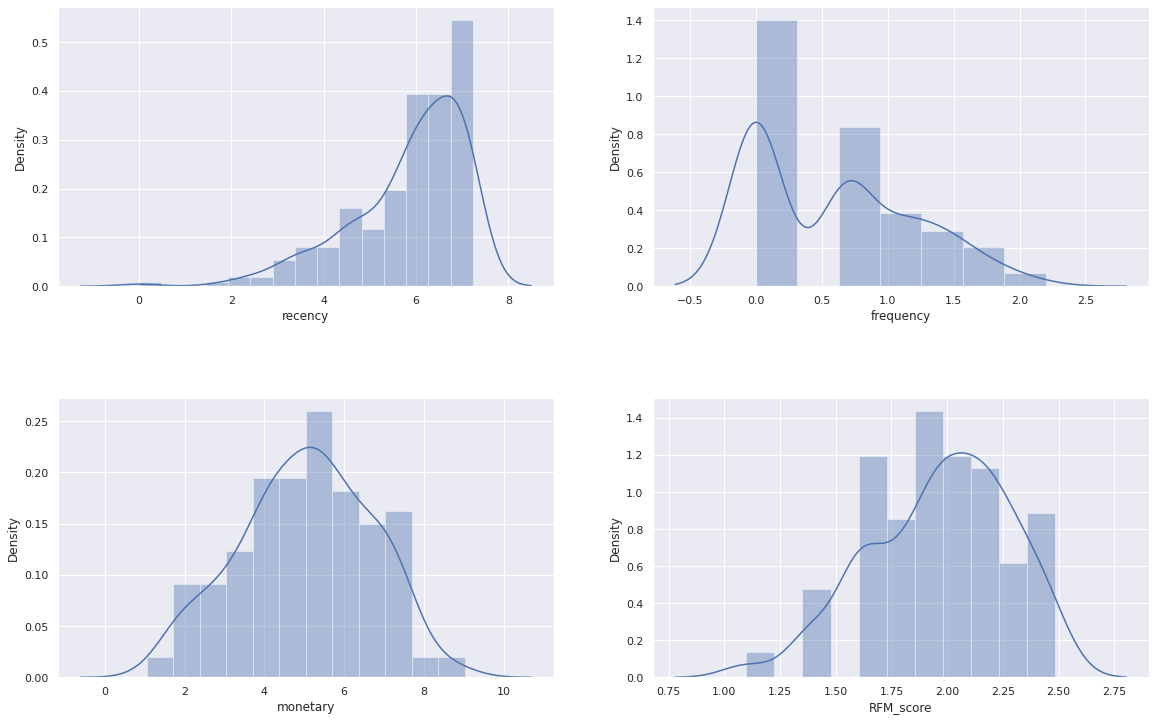

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()

sn.distplot(data_norm['recency'], ax=ax1)
sn.distplot(data_norm['frequency'], ax=ax2)
sn.distplot(data_norm['monetary'], ax=ax3)
sn.distplot(data_norm['RFM_score'], ax=ax4)

plt.subplots_adjust(wspace=0.2, hspace=0.4)

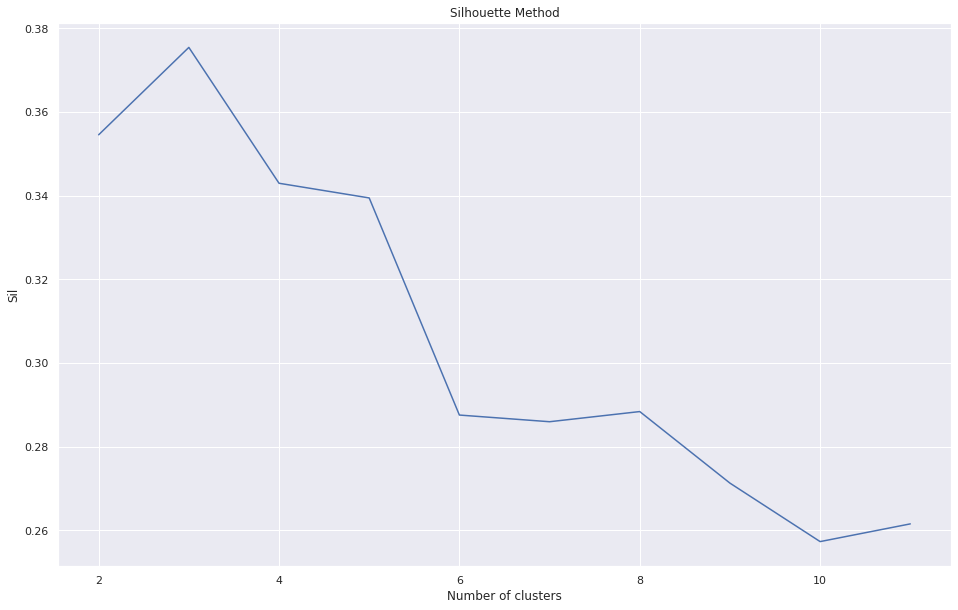

2:0.3545238473360516
3:0.37540252386013995
4:0.34294428172513797
5:0.3394377714481222
6:0.2875621729486967
7:0.2859675495575166
8:0.2883938952181037
9:0.27130006150678887
10:0.25732747781524395
11:0.2615592939414232


In [ ]:
sil = []

for k in range(2, 12):
  kmeans = KMeans(n_clusters = k).fit(data_norm)  
  preds = kmeans.fit_predict(data_norm)
  sil.append(silhouette_score(data_norm, preds, metric = 'euclidean'))


plt.plot(range(2, 12), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state=144).fit(data_norm)  
preds = kmeans.fit_predict(data_norm)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


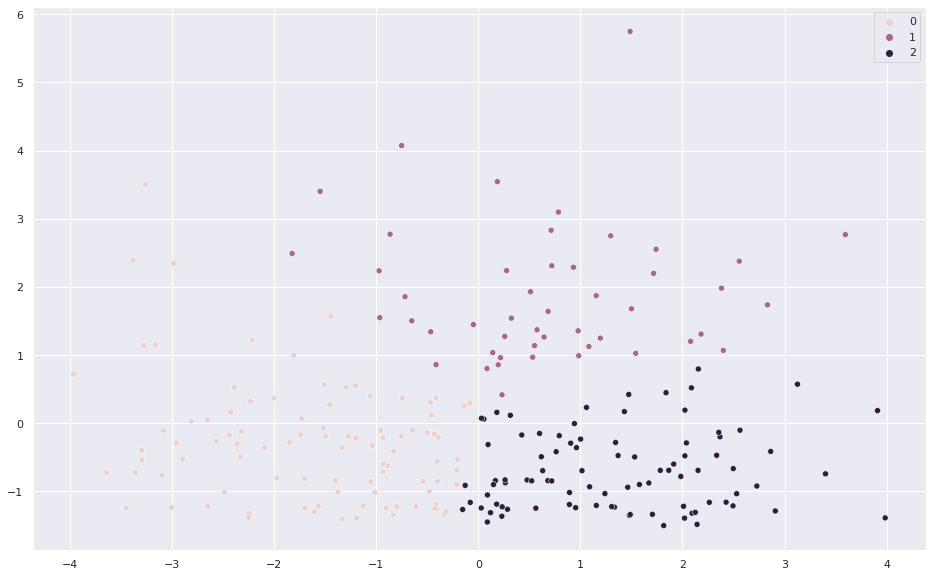

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_norm)

sn.scatterplot(pca_result[:,0], pca_result[:,1], hue=preds)

In [ ]:
SF_rfm['category'] = preds
c0 = SF_rfm[SF_rfm['category'] == 0]
c1 = SF_rfm[SF_rfm['category'] == 1]
c2 = SF_rfm[SF_rfm['category'] == 2]

In [ ]:
c0.describe()

,recency,frequency,monetary,RFM_score,category
count,95.000000,95.000000,95.000000,95.000000,95.0
mean,612.926316,1.378947,50.099453,5.631579,0.0
std,387.006741,0.717249,39.318379,1.288679,0.0
min,11.000000,1.000000,2.880000,3.000000,0.0
25%,312.000000,1.000000,15.768000,5.000000,0.0
50%,483.000000,1.000000,40.740000,5.000000,0.0
75%,886.000000,2.000000,72.336000,7.000000,0.0
max,1375.000000,4.000000,163.960000,9.000000,0.0


In [ ]:
c1.describe()

,recency,frequency,monetary,RFM_score,category
count,48.000000,48.000000,48.000000,48.000000,48.0
mean,73.437500,2.875000,496.383437,9.812500,1.0
std,49.530092,1.852256,689.930961,1.525057,0.0
min,1.000000,1.000000,25.830000,7.000000,1.0
25%,33.500000,1.750000,156.810000,9.000000,1.0
50%,73.000000,2.000000,237.372000,10.000000,1.0
75%,105.000000,4.000000,519.813500,11.000000,1.0
max,240.000000,9.000000,3955.507000,12.000000,1.0


In [ ]:
c2.describe()

,recency,frequency,monetary,RFM_score,category
count,89.000000,89.000000,89.000000,89.000000,89.0
mean,771.629213,2.707865,944.755494,8.247191,2.0
std,362.134248,1.568165,1242.182625,1.611612,0.0
min,154.000000,1.000000,135.936000,4.000000,2.0
25%,431.000000,2.000000,244.760000,7.000000,2.0
50%,796.000000,2.000000,479.970000,8.000000,2.0
75%,1127.000000,4.000000,1198.330000,9.000000,2.0
max,1382.000000,8.000000,8319.290000,12.000000,2.0


In [ ]:
df0 = SF_data[SF_data['customer_id'].isin(np.array(c0.customer_id))]
df1 = SF_data[SF_data['customer_id'].isin(np.array(c1.customer_id))]
df2 = SF_data[SF_data['customer_id'].isin(np.array(c2.customer_id))]

In [ ]:
t0 = df0.groupby(['order_id'], as_index=False).agg({'total_excl_vat': 'sum'}).rename(columns = {'total_excl_vat': 'order_size'})
t1 = df1.groupby(['order_id'], as_index=False).agg({'total_excl_vat': 'sum'}).rename(columns = {'total_excl_vat': 'order_size'})
t2 = df2.groupby(['order_id'], as_index=False).agg({'total_excl_vat': 'sum'}).rename(columns = {'total_excl_vat': 'order_size'})

In [ ]:
cnt0 = df0.groupby(['sub_category'], as_index=False).agg({'quantity': 'sum'}).rename(columns = {'quantity': 'total_quantity'})
cnt1 = df1.groupby(['sub_category'], as_index=False).agg({'quantity': 'sum'}).rename(columns = {'quantity': 'total_quantity'})
cnt2 = df2.groupby(['sub_category'], as_index=False).agg({'quantity': 'sum'}).rename(columns = {'quantity': 'total_quantity'})
cnt0['cat']=0
cnt1['cat']=1
cnt2['cat']=2

In [ ]:
disc0 = df0.groupby(['customer_id'], as_index=False).agg({'discount': 'mean'})
disc1 = df1.groupby(['customer_id'], as_index=False).agg({'discount': 'mean'})
disc2 = df2.groupby(['customer_id'], as_index=False).agg({'discount': 'mean'})
disc0['cat']=0
disc1['cat']=1
disc2['cat']=2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

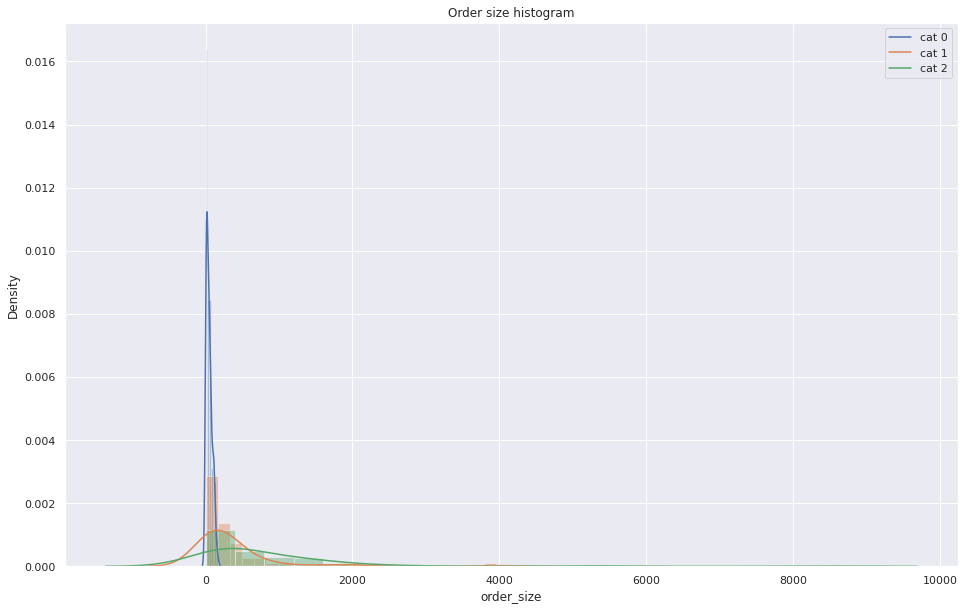

In [ ]:
sn.set(rc={'figure.figsize':(16,10)})

sn.distplot(t0['order_size'], kde=True)
sn.distplot(t1['order_size'], kde=True)
sn.distplot(t2['order_size'], kde=True)
# plt.axvline(np.mean(t1['order_size']),color='orange', linestyle='--')
plt.xlim=(-300, 5000)
plt.title("Order size histogram")
plt.legend(labels=['cat 0', 'cat 1', 'cat 2'])

In [ ]:
all_cnt = pd.concat([cnt0, cnt1, cnt2], ignore_index=True)
all_cnt.head()

,sub_category,total_quantity,cat
0,Accessories,23,0
1,Appliances,27,0
2,Art,52,0
3,Binders,93,0
4,Chairs,3,0


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

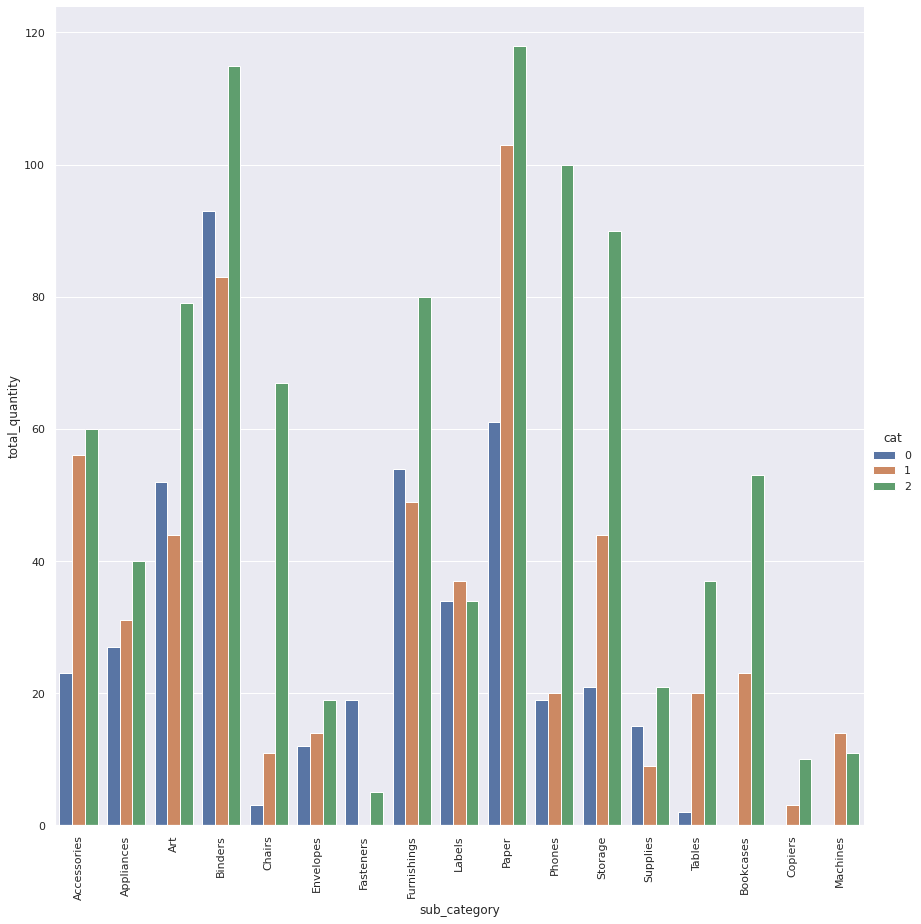

In [ ]:
sn.set(rc={'figure.figsize':(16,10)})
sn.factorplot(x='sub_category', y='total_quantity', hue='cat', data=all_cnt, kind='bar', height=12)
plt.xticks(rotation = 'vertical')

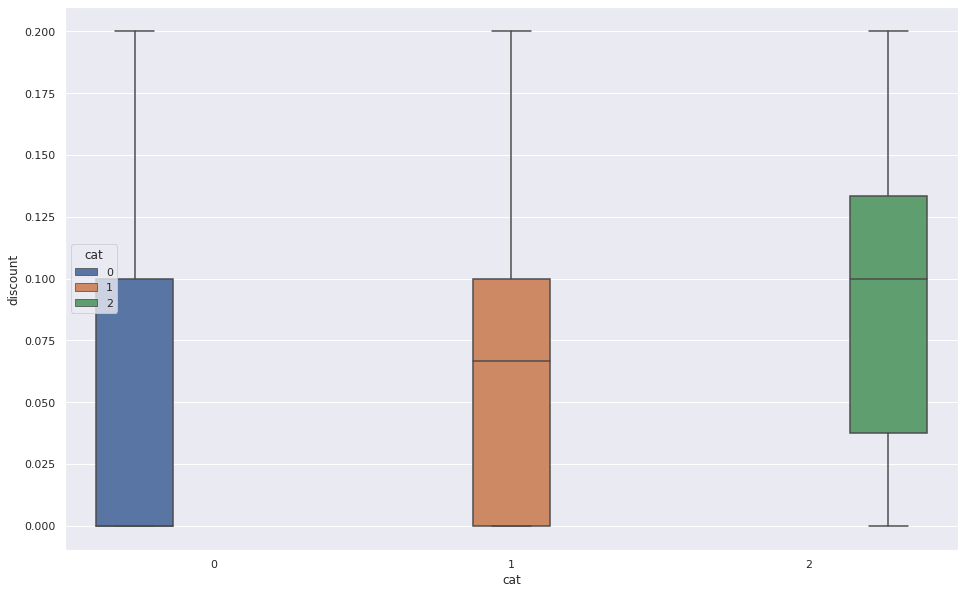

In [ ]:
all_disc = pd.concat([disc0, disc1, disc2], ignore_index=True)

sn.boxplot(x="cat", y='discount', hue="cat", data=all_disc)

In [ ]:
SF_ts = SF_data.groupby(['order_id'],as_index=False).agg({'order_date': 'first',
                                             'total_excl_vat': 'sum'})
SF_ts.head()

,order_id,order_date,total_excl_vat
0,CA-2014-100090,2014-07-08,699.192
1,CA-2014-103401,2014-11-21,12.960
2,CA-2014-104976,2014-12-09,34.680
3,CA-2014-105172,2014-04-04,18.900
4,CA-2014-105249,2014-11-28,460.092


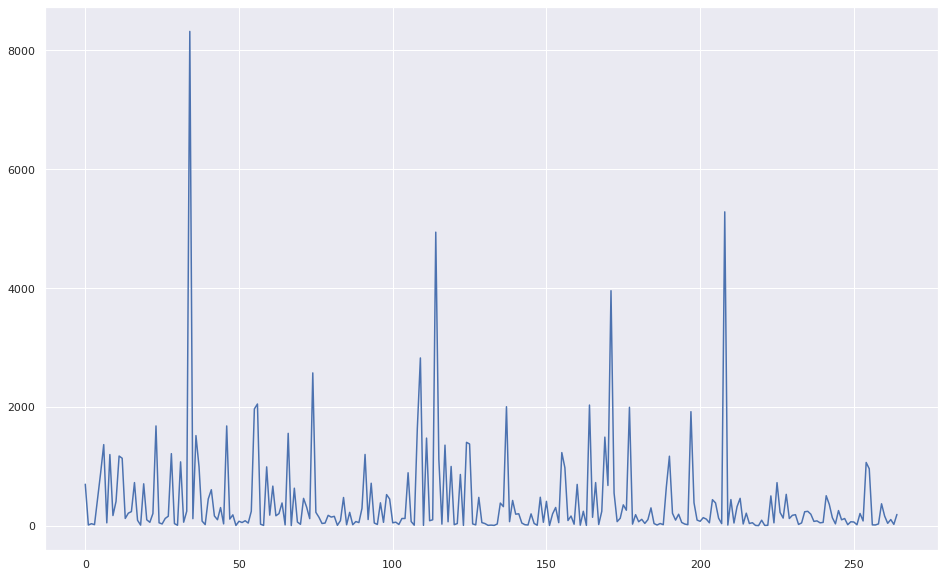

In [ ]:
plt.plot(SF_ts.total_excl_vat)

In [ ]:
SF_ts['order_date'] = pd.to_datetime(SF_ts['order_date'])
SF_ts['month_year'] = SF_ts['order_date'].dt.to_period('M')
SF_year_month = SF_ts.groupby(['month_year'],as_index=False).agg({
                                             'total_excl_vat': 'sum'})
SF_year_month.month_year = SF_year_month.month_year.dt.strftime('%Y-%m')
SF_year_month.head()

SF_year_month['date_ordinal'] = pd.to_datetime(SF_year_month['month_year']).apply(lambda date: date.toordinal())

[Text(0, 0, '2013-11-28'),
 Text(0, 0, '2014-06-16'),
 Text(0, 0, '2015-01-02'),
 Text(0, 0, '2015-07-21'),
 Text(0, 0, '2016-02-06'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2017-03-12'),
 Text(0, 0, '2017-09-28'),
 Text(0, 0, '2018-04-16')]

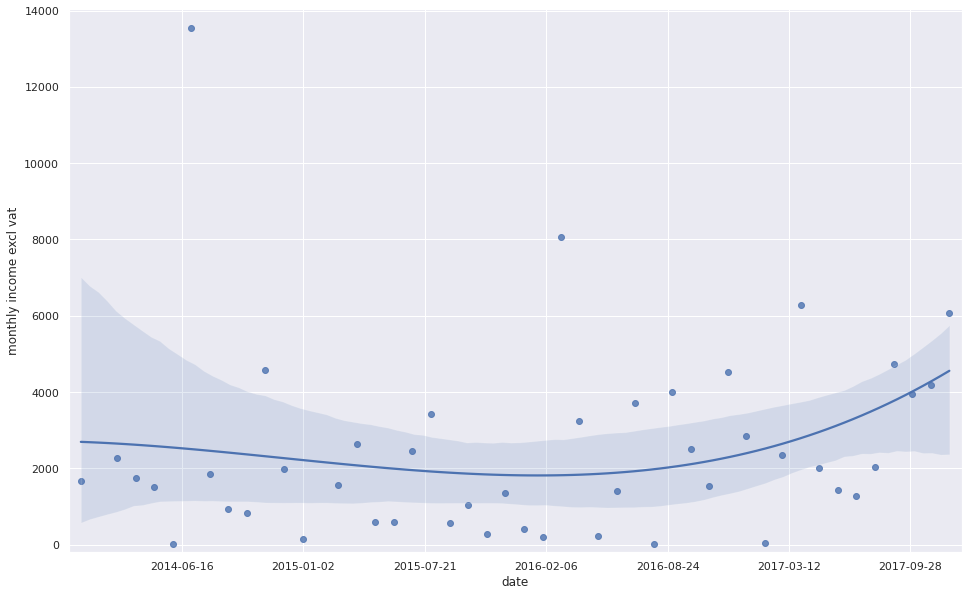

In [ ]:
ax = sn.regplot(
    data=SF_year_month,
    x='date_ordinal',
    y='total_excl_vat',
    order=3
    )
# Tighten up the axes for prettiness
ax.set_xlim(SF_year_month['date_ordinal'].min() - 20, SF_year_month['date_ordinal'].max() + 20)
ax.set_ylim(-200, SF_year_month['total_excl_vat'].max() + 500)

# change x labels
ax.set_xlabel('date')
ax.set_ylabel('monthly income excl vat')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)